In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
from mltrainer import Trainer, TrainerSettings, ReportTypes
import tomllib
import seaborn as sns
import numpy as np
from torch import Tensor
import math
from typing import List, Tuple, Dict, Any, Union
from src import datasets, metrics
import mltrainer
mltrainer.__version__

'0.1.129'

In [3]:
datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [8]:
trainfile = datadir / (config['arrhythmia'] + '_oversampled_full_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_oversampled_full_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

In [9]:
train_df = pd.read_parquet(trainfile)
test_df = pd.read_parquet(testfile)

In [10]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,target
10153,0.162791,0.540698,0.755814,0.186047,0.168605,0.546512,0.616279,0.697674,0.651163,0.703488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33886,0.990066,0.938742,0.344371,0.034768,0.273179,0.331126,0.326159,0.341060,0.347682,0.347682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32005,0.974239,0.932084,0.590164,0.131148,0.014052,0.168618,0.238876,0.210773,0.196721,0.208431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56159,0.978495,0.723118,0.526882,0.298387,0.220430,0.158602,0.091398,0.091398,0.080645,0.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61783,0.963351,0.709424,0.060209,0.013089,0.057592,0.041885,0.047120,0.034031,0.039267,0.044503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


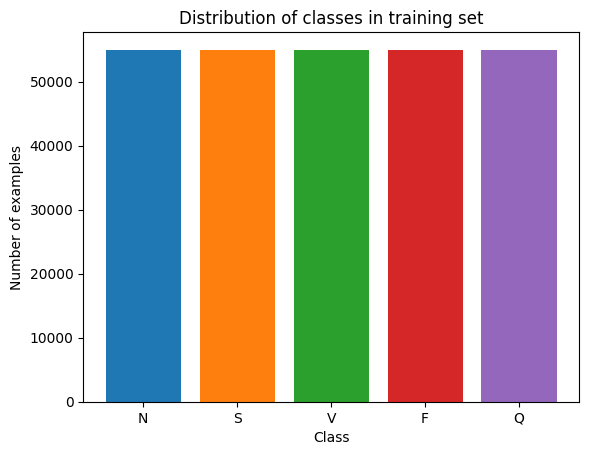

In [11]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
class_names = ['N', 'S', 'V', 'F', 'Q']
plt.bar(class_names, train_df.target.value_counts(), color = colors)

plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('Distribution of classes in training set')
plt.show()

Load the data

In [12]:
# load data in dataframes
train_df = pd.read_parquet(trainfile)
test_df = pd.read_parquet(testfile)

In [13]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

# moving to mps device crashes the jupyter kernel

(Heartdataset (len 275000), Heartdataset (len 21892))

In [14]:
x, y= traindataset[0]
x.shape, y.shape

(torch.Size([192, 1]), torch.Size([]))

Visualise it as 1D data

Set up the streamer

In [15]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(8593, 684)

In [16]:
x, y = next(trainstreamer.stream())
print(x.shape, y.shape)
x = x.unsqueeze(0)
x.shape

torch.Size([32, 192, 1]) torch.Size([32])


torch.Size([1, 32, 192, 1])

In [62]:

# Reshape the tensor to [32, 1, 16, 12]
reshaped_tensor = x.view(32, 1, 16, 12)

# Alternatively, you can use reshape
reshaped_tensor1 = x.reshape(32, 1, 16, 12)

print(reshaped_tensor1.shape)  # Output: torch.Size([32, 1, 16, 12])

torch.Size([32, 1, 16, 12])


Positional encoding to use with the transformer.

In [17]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_seq_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_seq_len, d_model)
        # batch, seq_len, d_model
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

Note, the layers have different assumptions about the data structure:
- streamer:         (batch, seq_len, channels)
- conv1d:           (batch, channels, seq_len)
- pos_encoding:     (batch, seq_len, channels)
- gru (batchfirst): (batch, seq_len, channels)
- attention:        (batch, seq_len, channels)

As you can see, its just the conv1d layer that expects channels as the second dimension. Using a conv1d layer you
will need to transpose the dimensions, I will show how to do that in the Transformer `forward` method.

Again, the strategy of creating a block helps us stack the architecture more easily.

In [18]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.conv(x)

In [19]:
import torch
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_blocks']):
            self.convolutions.extend([ConvBlock(hidden, hidden), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8*6) * hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [20]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        # feel free to change the input parameters of the constructor
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x):
        identity = x.clone() # skip connection
        x, _ = self.attention(x, x, x)
        x = self.layer_norm1(x + identity) # Add & Norm skip
        identity = x.clone() # second skip connection
        x = self.ff(x)
        x = self.layer_norm2(x + identity) # Add & Norm skip
        return x

class Transformer(nn.Module):
    def __init__(
        self,
        config: dict,
    ) -> None:
        super().__init__()
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_blocks']):
            self.convolutions.extend([ConvBlock(hidden, hidden), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        # self.conv1d = nn.Conv1d(
        #     in_channels=1,
        #     out_channels=config["hidden"],
        #     kernel_size=3,
        #     stride=2,
        #     padding=1,
        # )
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])

        # Create multiple transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        #self.out = nn.Linear(config["hidden"], config["output"])
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(config["hidden"], config["hidden"]//2),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["hidden"]//2, config['num_classes']),
        )
        #extra dense layers
        # self.out = nn.Sequential(
        #     nn.Linear(config["hidden"], config["hidden"]//2),
        #     nn.ReLU(),
        #     nn.Dropout(config["dropout"]),
        #     nn.Linear(config["hidden"]//2, config["output"]),
        # )

    def forward(self, x: Tensor) -> Tensor:
        # streamer:         (batch, seq_len, channels)
        # conv2d            (batch, channels, seq_len) [32, 1, 16, 12]
        # conv1d:           (batch, channels, seq_len) [32, 1, 192]
        # pos_encoding:     (batch, seq_len, channels)
        # attention:        (batch, seq_len, channels)
        #x = self.conv1d(x.transpose(1, 2)) # flip channels and seq_len for conv1d
        x = x.view(32, 1, 16, 12) # reshape to 2D
        for conv in self.convolutions:
            x = conv(x)
        x = self.pos_encoder(x.transpose(1, 2)) # flip back to seq_len and channels

        # Apply multiple transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        x = x.mean(dim=1) # Global Average Pooling
        x = self.out(x)
        return x

In [21]:
from src import models
config = {
    "hidden": 128,
    "dropout": 0.1,
    "output": 5,
    "num_heads": 8,
    "num_blocks": 1,
}
print(config)
model = models.Transformer(config)

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1}


Model 1D
Transofrmer block with 16 hidden units
Dropout  0.1
heads 4

Transformer is 1D conv
1 block
1 positional encoding

In [22]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

In [23]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [24]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("Transformer2D")

<Experiment: artifact_location='/Users/francesca/code_repo/MADS-exam-25/notebooks/mlruns/6', creation_time=1737304334725, experiment_id='6', last_update_time=1737304334725, lifecycle_stage='active', name='Transformer2D', tags={}>

In [25]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('MPS is available')
else:
    device = torch.device('cpu')

print(f"Model is on device: {next(model.parameters()).device}")


MPS is available
Model is on device: cpu


In [26]:
from sklearn.utils.class_weight import compute_class_weight
classes = train_df.target.unique()
class_weights = compute_class_weight('balanced', classes=classes, y=train_df.target)
class_weights_tensor = torch.tensor(class_weights).float().to(device)


In [27]:
# trainer without class weights + ReduceLROnPlateau scheduler
# training full oversampled dataset
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        #scheduler_kwargs={"factor": 0.7, "patience": 4},
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_big_fully_oversampled")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        #scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler=None
        )
    trainer.loop()

2025-01-19 23:33:03.006 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250119-233303
100%|██████████| 1718/1718 [00:36<00:00, 47.20it/s]
2025-01-19 23:33:40.719 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5630 test 0.4534 metric ['0.8352', '0.8352', '0.5786', '0.8352', '0.8735']
100%|██████████| 1718/1718 [00:36<00:00, 47.16it/s]
2025-01-19 23:34:18.313 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3108 test 0.4111 metric ['0.8557', '0.8557', '0.6252', '0.8557', '0.8977']
100%|██████████| 1718/1718 [00:36<00:00, 46.93it/s]
2025-01-19 23:34:55.945 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2519 test 0.2741 metric ['0.9115', '0.9115', '0.7058', '0.9115', '0.9029']
100%|██████████| 1718/1718 [00:36<00:00, 47.01it/s]
2025-01-19 23:35:33.538 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2161 test 0.1551 metric ['0.9545', '0.9545', '0.8146', '0.9545', '0.9250']
100%|██████████| 1718/1718 [00:36<00:0

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1}
test_results=[0.942 0.863 0.935 0.943 0.984]


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

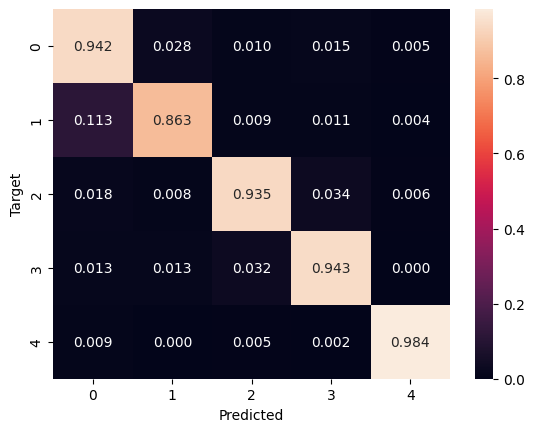

In [28]:

y_true = []
y_pred = []
#model = model.to("cpu")

#testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
print(f'test_results={np.round(cfm[cfm > 0.3], 3)}')
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [76]:
# trainer without class weights + ReduceLROnPlateau scheduler
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.7, "patience": 4},
        #scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        #scheduler=None
        )
    trainer.loop()

2025-01-19 18:23:04.452 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250119-182304
100%|██████████| 905/905 [00:19<00:00, 45.84it/s]
2025-01-19 18:23:25.202 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3048 test 0.1690 metric ['0.9543', '0.9543', '0.8139', '0.9543', '0.8658']
100%|██████████| 905/905 [00:19<00:00, 46.23it/s]
2025-01-19 18:23:45.818 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2617 test 0.1622 metric ['0.9478', '0.9478', '0.7916', '0.9478', '0.8617']
100%|██████████| 905/905 [00:19<00:00, 45.78it/s]
2025-01-19 18:24:06.592 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2246 test 0.1652 metric ['0.9534', '0.9534', '0.8197', '0.9534', '0.9053']
100%|██████████| 905/905 [00:19<00:00, 45.39it/s]
2025-01-19 18:24:27.616 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2028 test 0.1790 metric ['0.9506', '0.9506', '0.7871', '0.9506', '0.9091']
100%|██████████| 905/905 [00:20<00:00, 44.85it

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1}
test_results=[0.957 0.813 0.944 0.83  0.983]


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

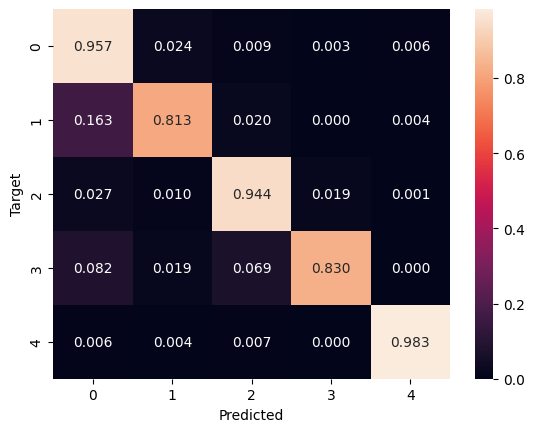

In [77]:
import seaborn as sns
import numpy as np


y_true = []
y_pred = []
#model = model.to("cpu")

#testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
print(f'test_results={np.round(cfm[cfm > 0.3], 3)}')
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [33]:
# difference between test and train
def calculate_difference(train_scores_str, test_scores_str):
    # Remove the brackets and split the string by spaces
    str_list = test_scores_str.strip('[]').split()

    # Convert each element to a float
    test_scores_str = [float(num) for num in str_list]

    test_scores = [float(x) for x in test_scores_str]
    train_scores = [float(x) for x in train_scores_str]
    difference = [str(np.round(test - train, 3)) for test, train in zip(test_scores, train_scores)]

    return difference


In [45]:
training_results=['0.9685', '0.9685', '0.8796', '0.9685', '0.9429']
test_results='[0.991 0.85  0.96  0.854 0.99 ]'
print(f'difference: {calculate_difference(training_results, test_results)}')

['0.022', '-0.119', '0.08', '-0.115', '0.047']
difference: ['0.022', '-0.119', '0.08', '-0.115', '0.047']


## Training with rebalanced class weights

In [78]:
#calculate class weights
classes = train_df.target.unique()
class_weights = compute_class_weight('balanced', classes=classes, y=train_df.target)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

In [89]:
config = {
    "hidden": 128,
    "dropout": 0.1,
    "output": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "shape": (16, 12)
}
print(config)
model = models.Transformer(config)

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


In [90]:
from mltrainer import Trainer, TrainerSettings, ReportTypes

loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        #scheduler_kwargs={"factor": 0.5, "patience": 2},
        scheduler=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_big_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    #mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        #device=device,
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        #scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler=None
        )
    trainer.loop()

2025-01-19 18:40:34.408 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250119-184034
100%|██████████| 905/905 [00:19<00:00, 45.82it/s]
2025-01-19 18:40:55.176 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5298 test 0.2844 metric ['0.9118', '0.9118', '0.7042', '0.9118', '0.8527']
100%|██████████| 905/905 [00:19<00:00, 45.34it/s]
2025-01-19 18:41:16.141 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3111 test 0.1776 metric ['0.9488', '0.9488', '0.7764', '0.9488', '0.8434']
100%|██████████| 905/905 [00:19<00:00, 45.73it/s]
2025-01-19 18:41:36.935 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2630 test 0.1717 metric ['0.9435', '0.9435', '0.7881', '0.9435', '0.9076']
100%|██████████| 905/905 [00:19<00:00, 45.79it/s]
2025-01-19 18:41:57.707 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2298 test 0.2227 metric ['0.9350', '0.9350', '0.7751', '0.9350', '0.8820']
100%|██████████| 905/905 [00:19<00:00, 45.63it

In [ ]:
from mltrainer import Trainer, TrainerSettings, ReportTypes

loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        #scheduler_kwargs={"factor": 0.5, "patience": 2},
        scheduler=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_big_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    #mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        #device=device,
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        #scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler=None
        )
    trainer.loop()

2025-01-19 18:40:34.408 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250119-184034
100%|██████████| 905/905 [00:19<00:00, 45.82it/s]
2025-01-19 18:40:55.176 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5298 test 0.2844 metric ['0.9118', '0.9118', '0.7042', '0.9118', '0.8527']
100%|██████████| 905/905 [00:19<00:00, 45.34it/s]
2025-01-19 18:41:16.141 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3111 test 0.1776 metric ['0.9488', '0.9488', '0.7764', '0.9488', '0.8434']
100%|██████████| 905/905 [00:19<00:00, 45.73it/s]
2025-01-19 18:41:36.935 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2630 test 0.1717 metric ['0.9435', '0.9435', '0.7881', '0.9435', '0.9076']
100%|██████████| 905/905 [00:19<00:00, 45.79it/s]
2025-01-19 18:41:57.707 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2298 test 0.2227 metric ['0.9350', '0.9350', '0.7751', '0.9350', '0.8820']
100%|██████████| 905/905 [00:19<00:00, 45.63it

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
test_results=[0.97  0.759 0.952 0.794 0.981]


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

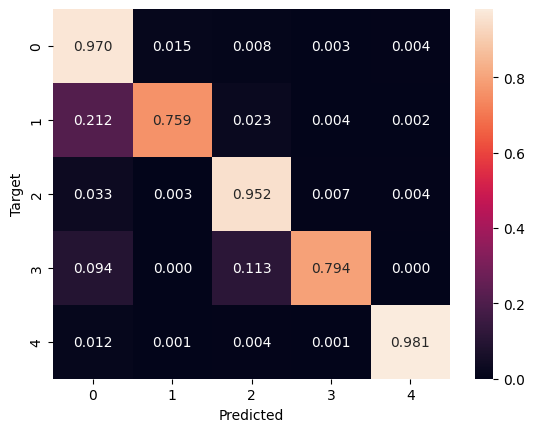

In [91]:
y_true = []
y_pred = []
#model = model.to("cpu")

#testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
print(f'test_results={np.round(cfm[cfm > 0.3], 3)}')
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [95]:
training_results=['0.9648', '0.9648', '0.8551', '0.9648', '0.9379']
test_results='[0.97 0.759 0.952 0.794 0.981]'
print(f'difference: {calculate_difference(training_results, test_results)}')

difference: ['0.005', '-0.206', '0.097', '-0.171', '0.043']


In [37]:
training_results=['0.9419', '0.9419', '0.7937', '0.9419', '0.9365']
test_results='[0.942 0.863 0.935 0.943 0.984]'
print(f'difference: {calculate_difference(training_results, test_results)}')

difference: ['0.0', '-0.079', '0.141', '0.001', '0.047']


In [ ]:
# Training with full oversampled dataset

In [125]:
from mltrainer import Trainer, TrainerSettings, ReportTypes

loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        #scheduler_kwargs={"factor": 0.5, "patience": 2},
        scheduler=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_big_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    #mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        #device=device,
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        #scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler=None
        )
    trainer.loop()

2025-01-19 19:35:50.987 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250119-193550
100%|██████████| 2717/2717 [00:59<00:00, 45.83it/s]
2025-01-19 19:36:51.328 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4443 test 0.7048 metric ['0.7001', '0.7001', '0.5082', '0.7001', '0.8452']
100%|██████████| 2717/2717 [00:59<00:00, 45.69it/s]
2025-01-19 19:37:51.815 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2388 test 0.4888 metric ['0.8217', '0.8217', '0.5873', '0.8217', '0.8921']
100%|██████████| 2717/2717 [00:59<00:00, 45.92it/s]
2025-01-19 19:38:52.001 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1954 test 0.4198 metric ['0.8316', '0.8316', '0.6331', '0.8316', '0.8842']
100%|██████████| 2717/2717 [00:59<00:00, 45.85it/s]
2025-01-19 19:39:52.287 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1661 test 0.2527 metric ['0.9037', '0.9037', '0.7066', '0.9037', '0.9185']
100%|██████████| 2717/2717 [00:59<00:0